# Using the Waveform.jl package to set up and solve a simple 2D Full Waveform Inversion problem

In [1]:
check_installed_pkgs = false

# Install the auxilary packages besides Waveform.jl, if needed
if check_installed_pkgs
    pkgs = Pkg.installed()
    # JOLI - Linear operator toolbox 
    if !("JOLI" in keys(pkgs))    
        Pkg.clone("git@github.com:slimgroup/JOLI.jl.git")
    end
    
    # PyPlot - plotting results
    if !("PyPlot" in keys(pkgs))
        Pkg.add("PyPlot")
    end

    # OptimPackNextGen - for the SPG algorithm (you can use your own if you have one)
    if !("OptimPackNextGen" in keys(pkgs))    
        Pkg.clone("git@github.com:emmt/OptimPackNextGen.jl.git")
        Pkg.build("OptimPackNextGen")
    end
end

In [2]:
using JOLI
using PyPlot
using OptimPackNextGen
using Waveform


In [3]:
# Set up the model geometry 
# In 2D, we organize our coordinates as (z,x) for legacy + visualization purposes

# Number of gridpoints in z-, x-
n = [101;101];

# Spacing of gridpoints in z-, x-
d = 10.0*[1;1];

# Origin point of domain in z-, x- (typically (0.,0.))
o = 0.0*[1;1];

# Constant velocity background
vel_background = 2500;

# Source wavelet time shift (in seconds)
t0 = 0.0;

# Peak frequency of Ricker Wavelet (in Hz)
f0 = 10.0;

# Units of the model 
unit = "m/s";

# Model domain range
L = n.*d;

# x-coordinates of the sources 
xsrc = 0.0:50.0:L[2];

# y-coordinates of the sources (irrelevant in 2D)
ysrc = [0.0];

# z-coordinates of the sources 
zsrc = [10.0];

# x-coordinates of the receivers
xrec = 0.0:10.0:L[2];

# y-coordinates of the receivers (irrelevant in 2D)
yrec = [0.0];

# z-coordinates of the receivers (this is a transmission experiment)
zrec = [950.0];

# Frequencies to compute 
freqs = [5.0;10.0;15.0];

# Maximum wavelength
λ = vel_background/maximum(freqs);

# Model type 
model = Model{Int64,Float64}(n,d,o,t0,f0,unit,freqs,xsrc,ysrc,zsrc,xrec,yrec,zrec);
(z,x) = odn_to_grid(o,d,n);
nsrc,nrec,nfreq = length(xsrc),length(xrec),length(freqs)

# Set up computational parameters
## Size/spacing of computational domain 
comp_n = n;
comp_d = d;
comp_o = o;

# Number of PML points
npml = round(Int,λ/minimum(comp_d))*[1 1; 1 1];

# PDE scheme
scheme = Waveform.helm2d_chen9p;

# Whether to remove elements in the PML when restricting to the model domain (if false, will use stacking)
cut_pml = true;

# If true, use an implicit matrix representation (false for 2D, the matrices are small enough to form explicitly)
implicit_matrix = false;

# Binary mask of the sources and frequencies to compute 
srcfreqmask = trues(nsrc,nfreq);

# Misfit function for the objective
misfit = least_squares;

# Linear solver options 
lsopts = LinSolveOpts(solver=:lufact);

# Computational options type
opts = PDEopts{Int64,Float64}(scheme,comp_n,comp_d,comp_o,cut_pml,implicit_matrix,npml,misfit,srcfreqmask,lsopts);

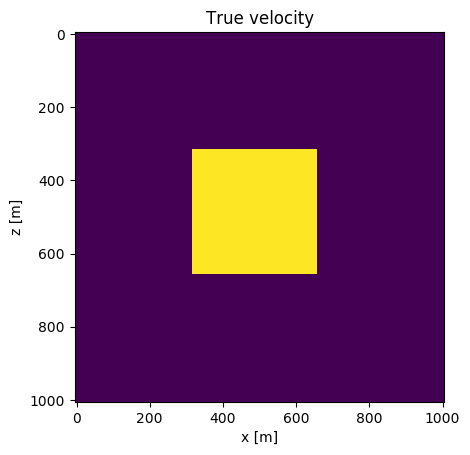

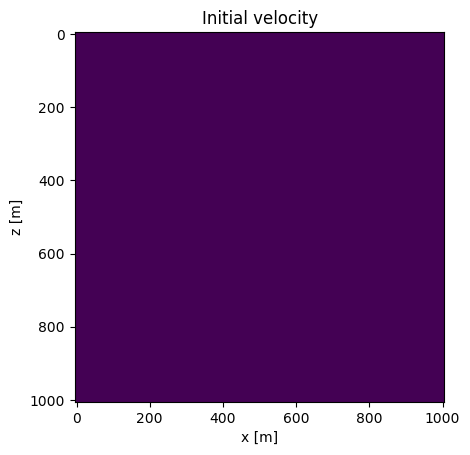

In [4]:
# Create velocity model
v0 = vel_background*ones(n...); 
v = copy(v0);
v[div(n[1],3):2*div(n[1],3),div(n[2],3):2*div(n[2],3)] = 1.25*vel_background;
v = vec(v);
v0 = vec(v0);

function plot_velocity(vs,title_str,model)
    fig = figure()
    ax1 = axes()
    vplot = imshow(reshape(vs,model.n...),vmin=minimum(v),vmax=maximum(v),axes=ax1)    
    title(title_str)
    xlabel("x [m]")
    ylabel("z [m]")
    zt = 0:20:n[1]
    xt = 0:20:n[2]
    xticks(xt,round.(Int,xt*model.d[2]))
    yticks(zt,round.(Int,zt*model.d[1]))
    return nothing
end
plot_velocity(v,"True velocity",model)
plot_velocity(v0,"Initial velocity",model)


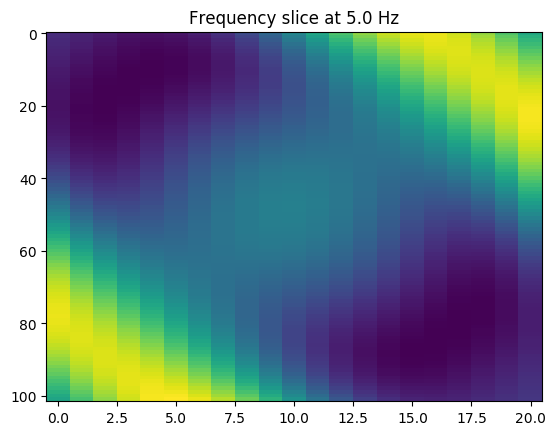

PyObject <matplotlib.text.Text object at 0x131d63a90>

In [5]:
# Source weight matrix
Q = eye(nsrc);

# Generate data
D = forw_model(v,Q,model,opts);

imshow(real(D[:,1:nsrc]),aspect="auto");
title("Frequency slice at $(model.freq[1]) Hz")

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{Float64}, ::Int64) at ./deprecated.jl:57
 [3] _spg!(::Waveform.##237#240{Array{Float64,2},Waveform.Model{Int64,Float64},Waveform.PDEopts{Int64,Float64}}, ::##9#10, ::Array{Float64,1}, ::Int64, ::OptimPackNextGen.SPG.SPGInfo, ::Int64, ::Int64, ::Float64, ::Float64, ::Float64, ::OptimPackNextGen.SPG.#default_printer, ::Bool, ::Base.PipeEndpoint) at /Users/curtd/.julia/v0.6/OptimPackNextGen/src/spg.jl:186
 [4] #spg!#2(::OptimPackNextGen.SPG.SPGInfo, ::Int64, ::Int64, ::Float64, ::Float64, ::Float64, ::Function, ::Bool, ::Base.PipeEndpoint, ::OptimPackNextGen.SPG.#spg!, ::Waveform.##237#240{Array{Float64,2},Waveform.Model{Int64,Float64},Waveform.PDEopts{Int64,Float64}}, ::##9#10, ::Array{Float64,1}, ::Int64) at /Users/curtd/.julia/v0.6/OptimPackNextGen/src/spg.jl:162
 [5] (::OptimPackNextGen.SPG.#kw##spg!)(::Array{Any,1}, ::OptimPackNextGen.SPG.#spg!, ::Function, ::Function, ::Array{Float64,1}, ::Int64) at

#  ITER   EVAL   PROJ             F(x)              ‖PG(X)‖_2 ‖PG(X)‖_∞
# ---------------------------------------------------------------------
      0      1      2 (*)  5.38359182406784385e+05  7.01e+01  1.88e+00
      1      2      4 (*)  5.35753403881357284e+05  7.00e+01  1.88e+00
      2      4      6 (*)  4.78797775855205895e+05  5.63e+01  1.33e+00
      3      5      8 (*)  1.41223686498247640e+05  2.63e+01  8.07e-01
      4      6     10 (*)  5.39738599327081101e+04  1.06e+01  4.18e-01
      5      7     12 (*)  3.26804670951108965e+04  7.32e+00  2.60e-01
      6      8     14 (*)  2.54826677347898549e+04  1.22e+01  2.93e-01
      7      9     16      3.45553147183280817e+04  2.01e+01  5.30e-01
      8     10     18 (*)  1.41584012270601506e+04  9.47e+00  3.23e-01
      9     11     20 (*)  9.45917235970044749e+03  3.05e+00  1.04e-01
     10     12     22 (*)  8.38363275154115036e+03  2.64e+00  8.93e-02
     11     13     24 (*)  4.56042501683483806e+03  2.39e+00  8.72e-02
    

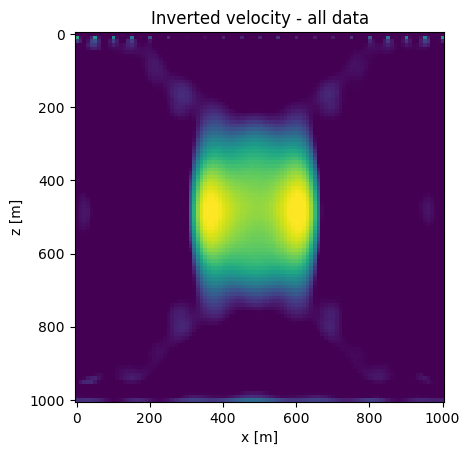

    25     30     52      1.05944494402255509e+03  1.77e+00  5.02e-02


In [6]:
max_func_evals = 30

# Construct objective function 
obj! = construct_pde_misfit(v,Q,D,model,opts,batch_mode=false)

# Project on to bound constraints
proj! = (xproj,x)->project_bounds!(x,minimum(v),maximum(v),xproj);

# Solve with SPG
vest = spg(obj!,proj!,v0,3,maxfc=max_func_evals,verb=true)


plot_velocity(vest,"Inverted velocity - all data",model)

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{Float64}, ::Int64) at ./deprecated.jl:57
 [3] _spg!(::Waveform.##237#240{Array{Float64,2},Waveform.Model{Int64,Float64},Waveform.PDEopts{Int64,Float64}}, ::##11#12, ::Array{Float64,1}, ::Int64, ::OptimPackNextGen.SPG.SPGInfo, ::Int64, ::Int64, ::Float64, ::Float64, ::Float64, ::OptimPackNextGen.SPG.#default_printer, ::Bool, ::Base.PipeEndpoint) at /Users/curtd/.julia/v0.6/OptimPackNextGen/src/spg.jl:186
 [4] #spg!#2(::OptimPackNextGen.SPG.SPGInfo, ::Int64, ::Int64, ::Float64, ::Float64, ::Float64, ::Function, ::Bool, ::Base.PipeEndpoint, ::OptimPackNextGen.SPG.#spg!, ::Waveform.##237#240{Array{Float64,2},Waveform.Model{Int64,Float64},Waveform.PDEopts{Int64,Float64}}, ::##11#12, ::Array{Float64,1}, ::Int64) at /Users/curtd/.julia/v0.6/OptimPackNextGen/src/spg.jl:162
 [5] (::OptimPackNextGen.SPG.#kw##spg!)(::Array{Any,1}, ::OptimPackNextGen.SPG.#spg!, ::Function, ::Function, ::Array{Float64,1}, ::Int64) 

#  ITER   EVAL   PROJ             F(x)              ‖PG(X)‖_2 ‖PG(X)‖_∞
# ---------------------------------------------------------------------
      0      1      2 (*)  5.79895427939140005e+05  8.66e+01  2.35e+00
      1      2      4 (*)  5.76735792121031554e+05  8.65e+01  2.35e+00
      2      3      6 (*)  3.94101350235808466e+05  6.69e+01  1.33e+00
      3      4      8 (*)  2.83087761133558452e+04  1.09e+01  3.52e-01
      4      5     10 (*)  1.78118499316859416e+04  5.24e+00  2.32e-01
      5      6     12 (*)  1.39770003112301201e+04  4.03e+00  1.53e-01
      6      7     14 (*)  8.62996386350487592e+03  2.90e+00  1.24e-01
      7      8     16      1.00583533155145433e+04  8.66e+00  2.31e-01
      8     10     18 (*)  3.52391405375565682e+03  1.48e+00  6.58e-02
      9     11     20 (*)  3.17807190323090299e+03  1.18e+00  5.84e-02
     10     12     22 (*)  2.38126703936331069e+03  1.02e+00  6.43e-02
     11     13     24      3.02786375346538398e+03  4.75e+00  1.66e-01
    

# WARNING: Too many function evaluations


#  ITER   EVAL   PROJ             F(x)              ‖PG(X)‖_2 ‖PG(X)‖_∞
# ---------------------------------------------------------------------
      0      1      2 (*)  9.78237925914344828e+02  8.90e-01  4.95e-02
      1      2      4 (*)  9.62608213654515907e+02  8.52e-01  4.85e-02
      2      3      6 (*)  7.24558234411916033e+02  1.04e+00  5.45e-02
      3      4      8 (*)  6.96367415474386917e+02  1.52e+00  5.36e-02
      4      5     10      9.53469765652548972e+02  3.44e+00  1.23e-01
      5      6     12 (*)  4.95693798695827411e+02  6.47e-01  2.21e-02
      6      7     14 (*)  4.67440704347849589e+02  3.96e-01  2.08e-02
      7      8     16 (*)  4.46175937971252040e+02  3.13e-01  2.21e-02
      8      9     18 (*)  3.45554972449355375e+02  2.43e-01  1.66e-02
      9     10     20 (*)  2.75420654238459974e+02  9.12e-01  3.66e-02
     10     15     22 (*)  2.51247977607493027e+02  1.03e+00  5.13e-02
     11     16     24 (*)  2.09805102475928521e+02  2.80e-01  1.32e-02
    

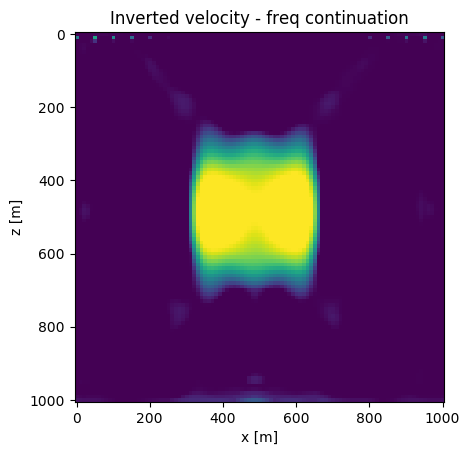

     22     30     46 (*)  1.32411613210654650e+02  1.08e-01  5.72e-03


# WARNING: Too many function evaluations


In [7]:
# Frequency continuation 
size_freq_batch = 2
overlap = 1
freq_partition = partition(nfreq,size_freq_batch,overlap)
vest = v0
opts1 = deepcopy(opts);
proj! = (xproj,x)->project_bounds!(x,minimum(v),maximum(v),xproj);

for j in 1:size(freq_partition,2)
    fbatch = freq_partition[:,j]
    srcfreqmask = falses(nsrc,nfreq)
    srcfreqmask[:,fbatch] = true
    opts1.srcfreqmask = srcfreqmask
    obj! = construct_pde_misfit(v,Q,D,model,opts1,batch_mode=false)
    vest = spg(obj!,proj!,vest,3,maxfc=max_func_evals,verb=true)
end
plot_velocity(vest,"Inverted velocity - freq continuation",model)